In [1]:
from __future__ import absolute_import, division, print_function

import datetime
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4
import json
import pandas as pd
import numpy as np
import calendar
import time as t
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.api as sm
import urllib
import copy
from xml.etree import cElementTree as ET

In [2]:
# This function returns the first and last available time from a url of a getcapabilities page located on a Thredds Server
def getTimeBounds(url):
    f=urllib.urlopen(url)
    tree=ET.parse(f)
    root=tree.getroot()
    #These lines of code find the time dimension information for the netcdf on the Thredds server
    dim=root.findall('.//{http://www.opengis.net/wms}Dimension')
    dim=dim[0].text
    times=dim.split(',')
    times.pop(0)
    timemin=times[0]
    timemax=times[-1]
    #timemin and timemax are the first and last available times on the specified url
    return timemin,timemax
#This function returns a pandas dataframe of the timeseries values of a specific layer 
#at a specific latitude and longitude from a file on a Thredds server
#server: the url of the netcdf desired netcdf file on the Thredds server to read
#layer: the name of the layer to extract timeseries information from for the netcdf file
#lat: the latitude of the point at which to extract the timeseries
#lon: the longitude of the point at which to extract the timeseries
#returns df: a pandas dataframe of the timeseries at lat and lon for the layer in the server netcdf file
def getThreddsValue(server,layer,lat,lon):
    #calls the getTimeBounds function to get the first and last available times for the netcdf file on the server
    timemin,timemax=getTimeBounds(server+"?service=WMS&version=1.3.0&request=GetCapabilities")
    #These lines properly format a url request for the timeseries of a speific layer from a netcdf on 
    #a Thredds server
    server=server+"?service=WMS&version=1.3.0&request=GetFeatureInfo&CRS=CRS:84&QUERY_LAYERS="+layer
    server=server+"&X=0&Y=0&I=0&J=0&BBOX="+str(lon)+','+str(lat)+','+str(lon+.001)+','+str(lat+.001)
    server=server+"&WIDTH=1&Height=1&INFO_FORMAT=text/xml"
    server=server+'&TIME='+timemin+'/'+timemax
    f = urllib.urlopen(server)
    tree=ET.parse(f)
    root=tree.getroot()
    features=root.findall('FeatureInfo')
    times=[]
    values=[]
    for child in features:
        time=datetime.datetime.strptime(child[0].text,"%Y-%m-%dT%H:%M:%S.%fZ")
        times.append(time)
        values.append(child[1].text)
    
    df=pd.DataFrame(index=times, columns=[layer],data=values)
    df[layer]=df[layer].replace('none',np.nan).astype(float)
    return df

#function to convert a datetime object to milliseconds since epoch
def datetime_to_float(d):
    epoch = datetime.datetime.utcfromtimestamp(0)
    total_seconds =  (d - epoch).total_seconds()
    # total_seconds will be in decimals (millisecond precision)
    return total_seconds

mylat=37.6
mylon=-113.7
server="https://www.esrl.noaa.gov/psd/thredds/wms/Datasets/dai_pdsi/pdsi.mon.mean.selfcalibrated.nc"
layer="pdsi"
#calls a function to return a df of the timeseries of the pdsi at 37.7,-113
df1=getThreddsValue(server,layer,mylat,mylon)

server="https://www.esrl.noaa.gov/psd/thredds/wms/Datasets/cpcsoil/soilw.mon.mean.nc"
layer="soilw"
names=['pdsi','soilw']
#calls a function to return a df of the timeseries of the soilw at 37.7,-113
df=getThreddsValue(server,layer,mylat,mylon)
#joins the two dataframes (df and df1) together into the same timeseries dataframe
# try:
#     datafile='texas_'+str(mylat)+','+str(mylon)+'.0.txt'
#     data=pd.read_csv(datafile, header=10,sep='\t',parse_dates=True,names=["soilm"])
# except:
#     datafile='texas_'+str(mylat)+','+str(mylon)+'.txt'
#     data=pd.read_csv(datafile, header=10,sep='\t',parse_dates=True,names=["soilm"])
# df2=data.resample('M').mean()
# server="https://wci.earth2observe.eu/thredds/wms/vu/gleam-v3c-agg-smroot.nc"
# layer="SMroot"
# #calls a function to return a df of the timeseries of the soilw at 37.7,-113
# df2=getThreddsValue(server,layer,mylat,mylon)
# #joins the two dataframes (df and df1) together into the same timeseries dataframe

gldas_df=pd.concat([df, df1], join="outer", axis=1)
#resamples the data from both datasets to a monthly mean
gldas_df.interpolate(method='pchip', inplace=True, limit_area='inside')
gldas_df=gldas_df.resample('M').mean()
newnames=copy.deepcopy(names)

years=[1,3,5,10]
#This loop adds the yearly, 3-year, 5-year, and 10-year rolling averages of each variable to the dataframe
for name in names:
    for year in years:
        new=name+'_year'+str(year)
        gldas_df[new]=gldas_df[name].rolling(year*12).mean()
        newnames.append(new)
names=newnames
newnames=copy.deepcopy(names)
offsets=[.25,.5,.75,1,1.5,2,3]
for name in names:
    for year in offsets:
        new=name+'_offset'+str(year)
        gldas_df[new]=gldas_df[name].shift(int(year*12))
        newnames.append(new)
names=newnames
print("done")

done


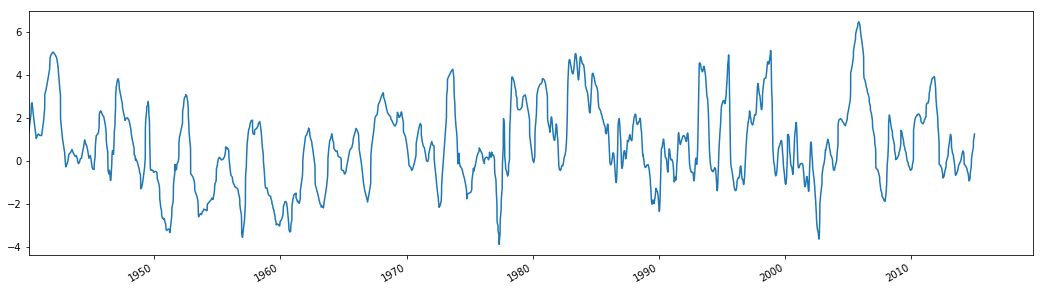

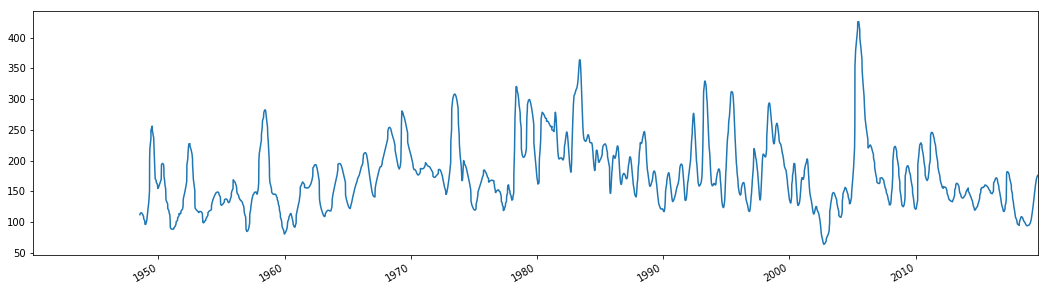

In [3]:
#This code includes a for loop to add the timeseries data for each well in the Cedar Valley Utah 
#aquifer which has dat from 1950 to 2015 and more than 20 samples of data
#these timeseries data are added to a pandas dataframe called combined_df 
with open('Escalante_Valley-Beryl-Enterprise.json','r') as f:
    wells=json.load(f)
combined_df=pd.DataFrame()
mywells=[]
for well in wells['features']:
    if 'TsTime' in well:
        if len(well['TsTime'])>50:# and well['geometry']['coordinates'][0]<=mylon and well['geometry']['coordinates'][0]>=mylon-.5:
            #if well['geometry']['coordinates'][1]<=mylat and well['geometry']['coordinates'][1]>=mylat-.5:
            if np.array(well['TsTime']).max()>calendar.timegm(datetime.datetime(2005, 1, 1).timetuple()) and np.array(well['TsTime']).min()<calendar.timegm(datetime.datetime(1975, 1, 1).timetuple()):
                name = str(well['properties']['HydroID'])
                mywells.append(name)
                wells_df = pd.DataFrame(index=pd.to_datetime(well['TsTime'], unit='s', origin='unix'), data=well['TsValue'], columns=[name])
                wells_df = wells_df[np.logical_not(wells_df.index.duplicated())]
                try:
                    combined_df = pd.concat([combined_df, wells_df], join="outer", axis=1, sort=False)
                    combined_df.drop_duplicates(inplace=True)
                except Exception as e:
                    print(e)
                    break
#The data from the wells and the satellite observations are combined to a single dataframe (combined_df)
combined_df=pd.concat([combined_df,gldas_df], join="outer", axis=1, sort=False)
#The data are interpolated so that they are resampled to a monthy frequency
combined_df.interpolate(method='pchip', inplace=True, limit_area='inside')

start_date=1900
# combined_df=combined_df.resample('3M').mean()
# decemb=combined_df.index.get_loc(str(start_date)+'-12-31 00:00:00',method='nearest') % 4
# combined_df=combined_df.iloc[decemb::4]

#plots to compare the 10 year mean of pdsi, soilw, and the observed water level at a well from 1940 on
combined_df['pdsi'].rolling(10).mean()['1940':].plot(figsize=(18,5))
plt.show()
combined_df['soilw'].rolling(10).mean()['1940':].plot(figsize=(18,5))
plt.show()

#drop empty dates from the dataframe
#We now have monthy data from January 1958 to December 2014
combined_df=combined_df.dropna(axis=1,how='all')
combined_df.dropna(subset=names,inplace=True)
length=len(combined_df.columns)-1
combined_df2=combined_df.copy()

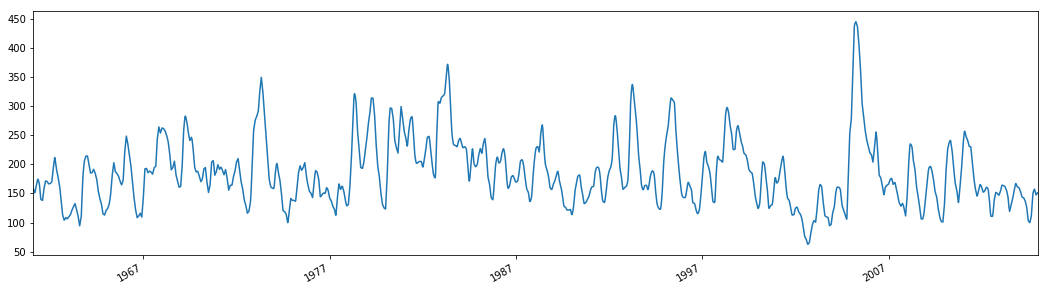

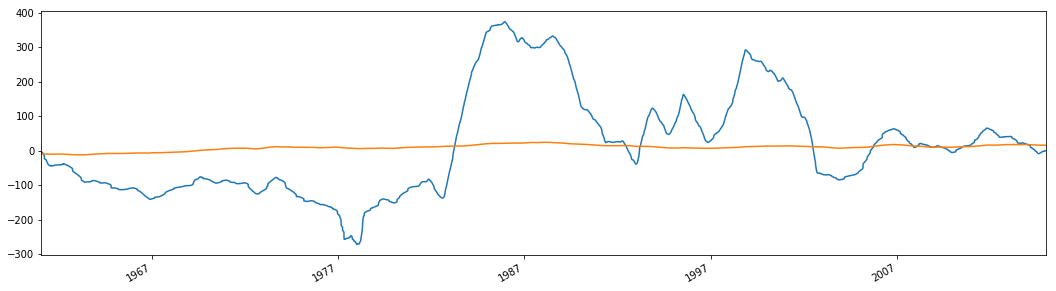

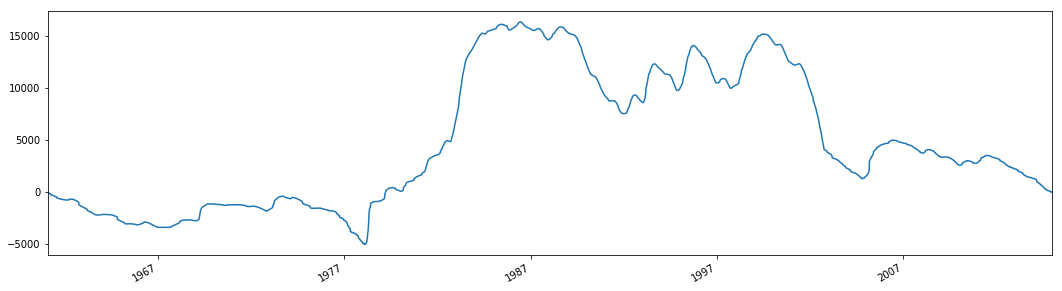

Index([u'373338113431502', u'373419113434201', u'373527113415101',
       u'373644113411501', u'373735113393801', u'373854113411501',
       u'374020113343101', u'374041113373501', u'374053113415101',
       u'374228113420101',
       ...
       u'soilw_year5_offset3', u'soilw_year10_offset0.25',
       u'soilw_year10_offset0.5', u'soilw_year10_offset0.75',
       u'soilw_year10_offset1', u'soilw_year10_offset1.5',
       u'soilw_year10_offset2', u'soilw_year10_offset3', u'pdsi_int',
       u'soilw_int'],
      dtype='object', length=107)


In [4]:
combined_df['soilw'].plot(figsize=(18,5))
plt.show()
# (combined_df['soilw']['1960':]-combined_df['soilw'].mean()).cumsum().plot(figsize=(18,5))
(combined_df['pdsi']['1960':]-combined_df['pdsi'].mean()).cumsum().plot(figsize=(18,5))
combined_df['pdsi_int']=(combined_df['pdsi']['1960':]-combined_df['pdsi'].mean()).cumsum()
(combined_df['pdsi_year10']['1960':]*12).plot()
# (met-met.mean()).cumsum().plot(figsize=(18,5))
plt.show()
(combined_df['soilw']['1960':]-combined_df['soilw'].mean()).cumsum().plot(figsize=(18,5))
combined_df['soilw_int']=(combined_df['soilw']['1960':]-combined_df['soilw'].mean()).cumsum()
# (met-met.mean()).cumsum().plot(figsize=(18,5))
plt.show()
names.append('soilw_int')
names.append('pdsi_int')
print(combined_df.columns)

373338113431502
['pdsi_year3' 'soilw_year3' 'pdsi_year3_offset0.25' 'soilw_year1'
 'soilw_year3_offset0.25']
[0.66749182 0.6554327  0.6188658  0.60718156 0.60665482]


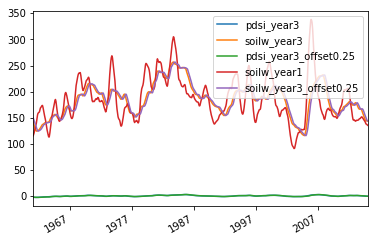

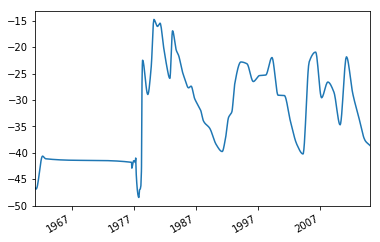

373419113434201
['soilw_year1' 'pdsi_year3' 'soilw_year3' 'pdsi_year1'
 'soilw_year1_offset0.25']
[0.67388607 0.66905572 0.66469075 0.63310337 0.60269345]


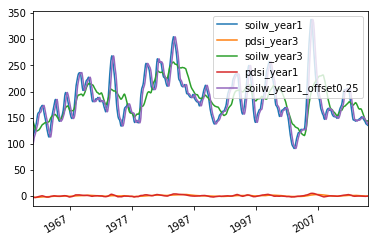

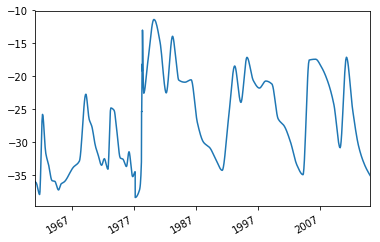

373527113415101
['soilw_year3' 'soilw_year3_offset0.25' 'soilw_year1_offset0.5'
 'soilw_year1_offset0.25' 'soilw_year3_offset0.5']
[0.71046029 0.68637675 0.67853628 0.67120215 0.64593259]


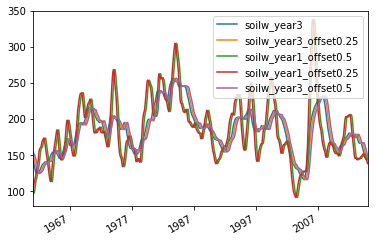

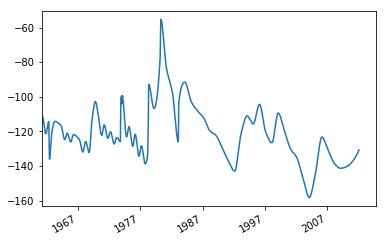

373644113411501
['soilw_year3' 'soilw_year1' 'soilw_year1_offset0.25' 'soilw_year5'
 'soilw_year1_offset0.5']
[0.33406159 0.32465237 0.32371386 0.31873528 0.3183101 ]


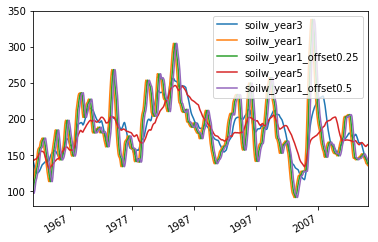

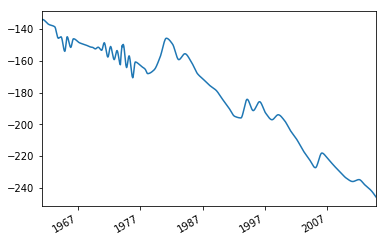

373735113393801
['soilw_year1' 'soilw' 'soilw_year1_offset0.25' 'soilw_offset0.75'
 'soilw_year3']
[0.249122   0.24441458 0.22509816 0.20702527 0.20673712]


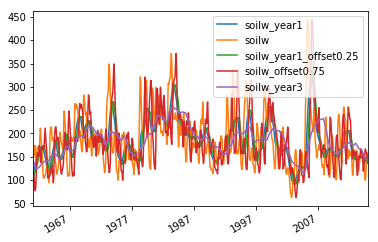

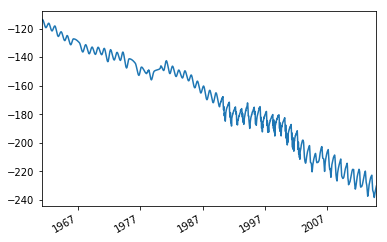

373854113411501
['soilw_year1' 'soilw_year1_offset0.25' 'soilw_year1_offset0.5'
 'soilw_year3' 'soilw']
[0.27882094 0.26268441 0.24803684 0.24049372 0.22640068]


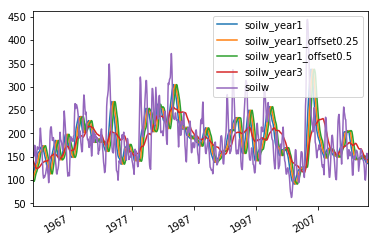

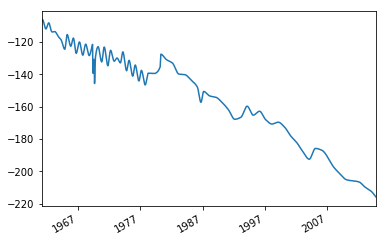

374020113343101
['soilw_year1' 'soilw_year1_offset0.25' 'soilw_year1_offset0.5' 'soilw'
 'soilw_year3']
[0.21719474 0.20137312 0.18670386 0.17829879 0.17817482]


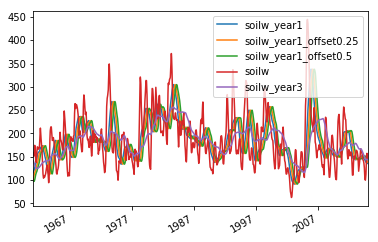

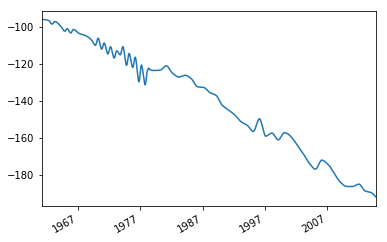

374041113373501
['soilw_year1' 'soilw' 'soilw_year1_offset0.25' 'soilw_year1_offset0.5'
 'soilw_year3']
[0.19324535 0.17485981 0.1721091  0.15747361 0.15127704]


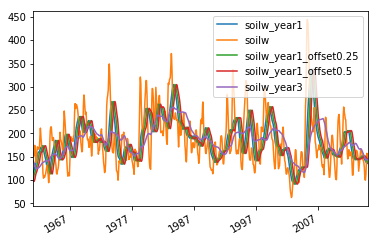

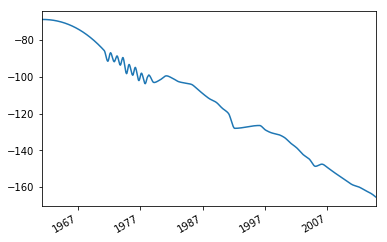

374053113415101
['soilw_year1' 'soilw' 'soilw_year1_offset0.25' 'soilw_year1_offset0.5'
 'soilw_offset0.75']
[0.20060731 0.18801794 0.1826278  0.1649573  0.15135424]


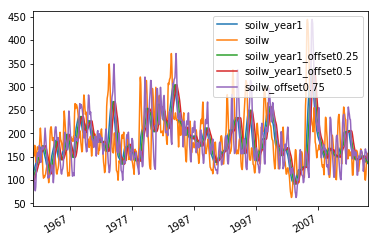

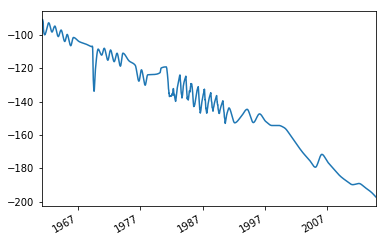

374228113420101
['soilw_year1' 'soilw_year1_offset0.25' 'soilw' 'soilw_year1_offset0.5'
 'soilw_offset0.5']
[0.20532235 0.18370699 0.18184062 0.16545323 0.15325448]


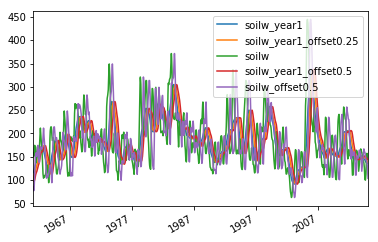

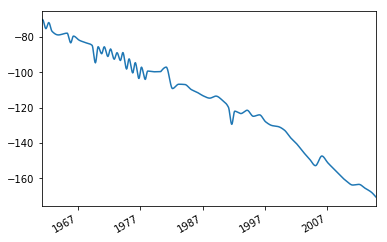

374252113385801
['soilw_year5' 'soilw_year1' 'soilw_year3' 'soilw_year5_offset0.25'
 'soilw_year5_offset0.5']
[0.30819157 0.29897002 0.29804533 0.29475119 0.28256973]


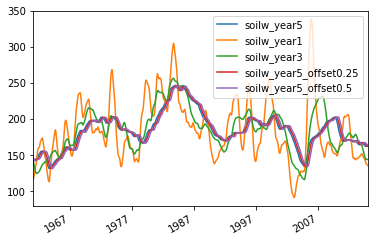

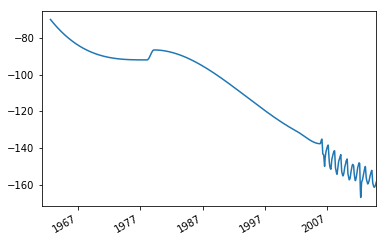

374319113415201
['soilw_year1' 'soilw_year1_offset0.25' 'soilw' 'soilw_year1_offset0.5'
 'soilw_year3']
[0.22247451 0.20269675 0.19385481 0.18787006 0.17998087]


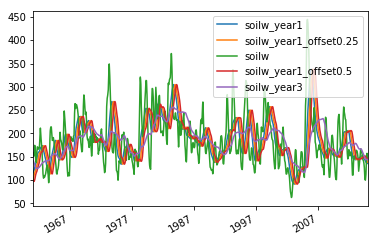

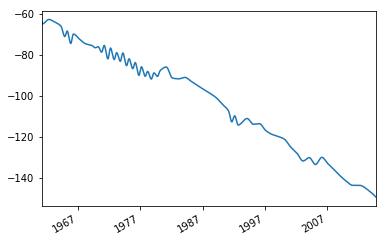

374344113322403
['soilw_year1' 'soilw_year1_offset0.25' 'soilw_year1_offset0.5' 'soilw'
 'soilw_year3']
[0.23631191 0.21988959 0.20585096 0.19389524 0.19133935]


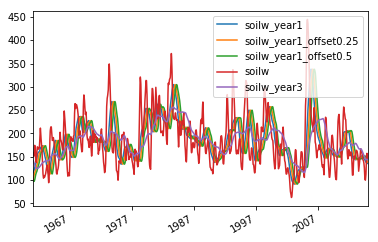

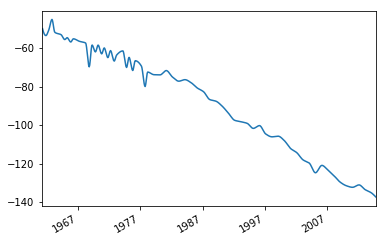

374411113305101
['soilw_year1' 'soilw_year1_offset0.25' 'soilw' 'soilw_year1_offset0.5'
 'soilw_year3']
[0.21211046 0.19266678 0.18466242 0.17833311 0.17277072]


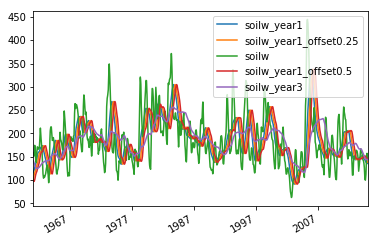

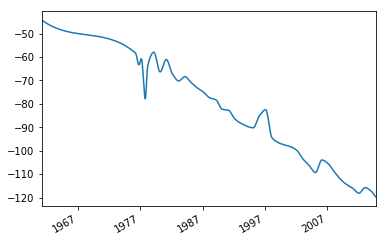

374445113444501
['soilw_year1' 'soilw' 'soilw_year1_offset0.25' 'soilw_year1_offset0.5'
 'soilw_offset0.5']
[0.1996893  0.19169537 0.1719826  0.15336846 0.14625522]


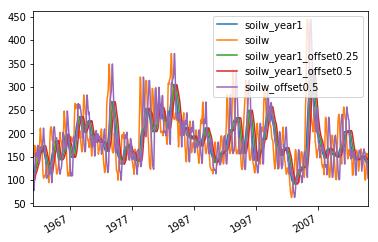

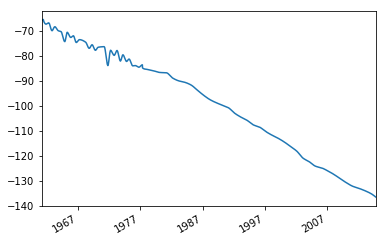

374503113313701
['soilw_year1_offset0.25' 'soilw_year1_offset0.5' 'soilw_year1'
 'soilw_year3' 'soilw_year5']
[0.2439376  0.23596042 0.23107238 0.21930888 0.21688844]


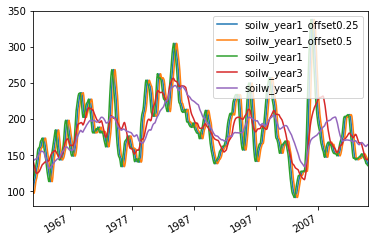

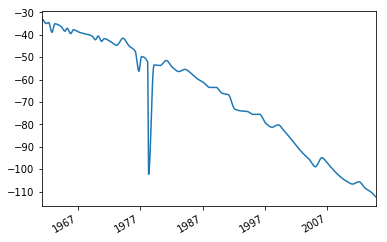

374505113433701
['soilw_year1' 'soilw' 'soilw_year1_offset0.25' 'soilw_year3'
 'soilw_year1_offset0.5']
[0.22141522 0.20951846 0.19167331 0.17537772 0.17327474]


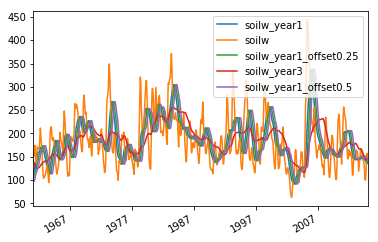

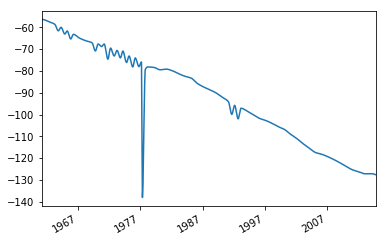

374649113310201
['soilw_year1' 'soilw_year1_offset0.25' 'soilw' 'soilw_year1_offset0.5'
 'soilw_offset0.75']
[0.22821476 0.20920042 0.19513522 0.19276677 0.17504435]


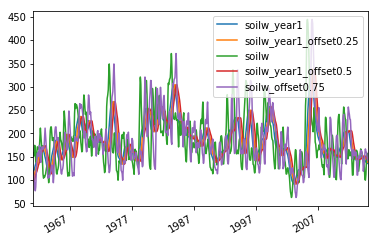

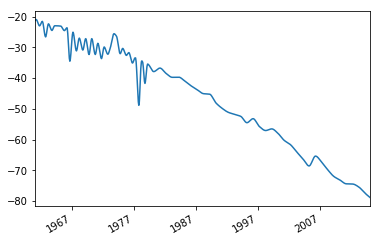

374649113342501
['soilw_year1' 'soilw' 'soilw_year1_offset0.25' 'soilw_offset0.5'
 'soilw_year1_offset0.5']
[0.18129305 0.17463653 0.15363205 0.135417   0.13450071]


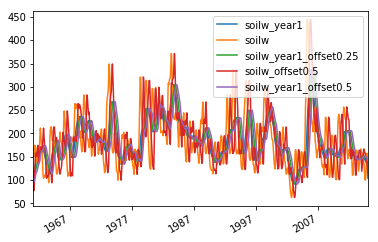

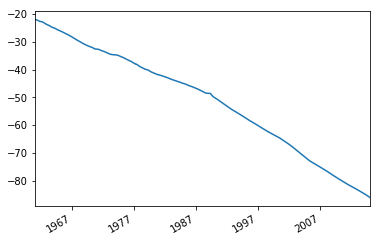

374649113444801
['soilw_year1' 'soilw' 'soilw_year1_offset0.25' 'soilw_year1_offset0.5'
 'soilw_offset0.5']
[0.20176233 0.19232426 0.17427908 0.15486204 0.14717297]


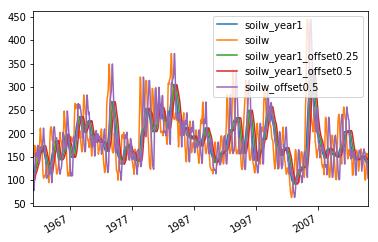

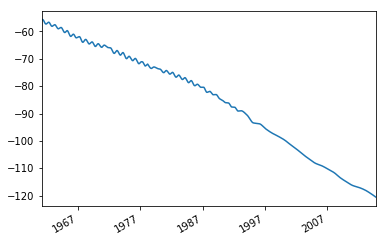

374808113420301
['soilw_year1' 'soilw' 'soilw_year1_offset0.25' 'soilw_year1_offset0.5'
 'soilw_offset0.5']
[0.19609425 0.19393044 0.16752527 0.14845518 0.14022748]


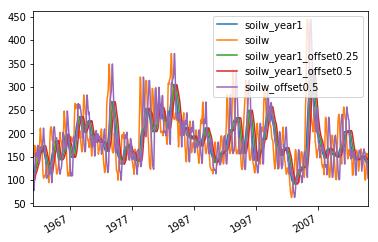

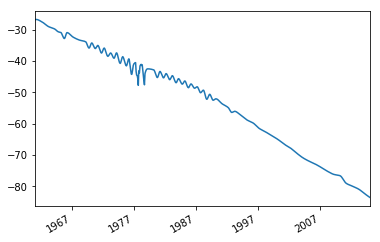

374833113402401
['soilw_year1' 'soilw' 'soilw_year1_offset0.25' 'soilw_year1_offset0.5'
 'soilw_year3']
[0.20895167 0.19580683 0.1807099  0.16122091 0.1577393 ]


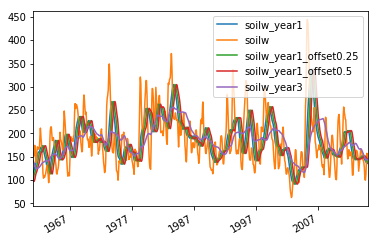

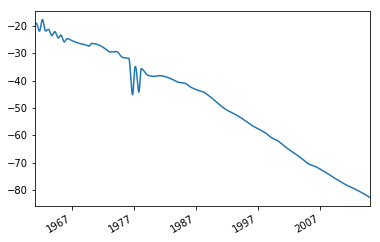

375324113345301
['soilw_year1' 'soilw_year1_offset0.25' 'soilw_year1_offset0.5'
 'soilw_year3' 'soilw_year5']
[0.22951841 0.20980828 0.19586128 0.19549657 0.19216532]


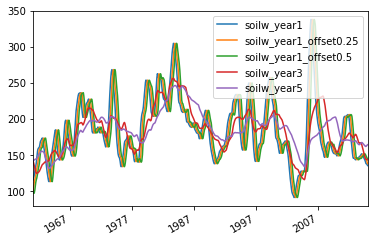

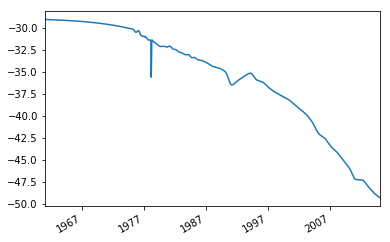

375429113403901
['soilw_year1' 'soilw' 'soilw_year1_offset0.25' 'soilw_year5'
 'soilw_offset0.5']
[0.19295055 0.18414744 0.16275752 0.15100273 0.14590786]


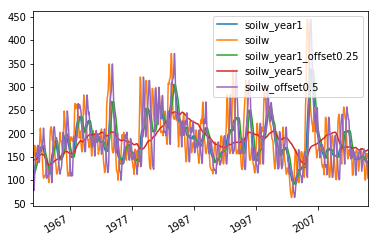

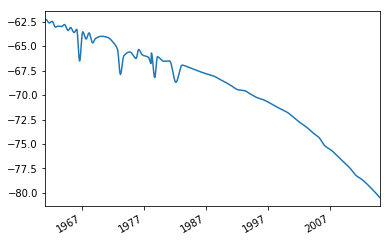

375531113361901
['soilw' 'soilw_year1' 'soilw_year1_offset0.25' 'soilw_offset0.75'
 'soilw_offset0.5']
[0.21113426 0.15789887 0.11217822 0.107069   0.10233401]


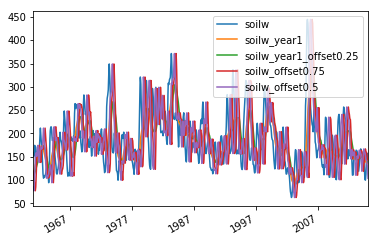

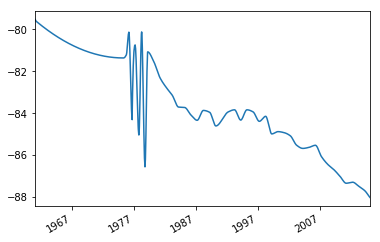

In [5]:
# combined_df2[mywells]=combined_df2[mywells].diff()
corr_df=combined_df2.corr(min_periods=12).drop(mywells)
for i in range(0,len(mywells)):
    reflist=np.array(corr_df.nlargest(5,corr_df.columns[i]).index)
    corr_values=corr_df.nlargest(5, corr_df.columns[i]).values[:,i]
    print(corr_df.columns[i])
    print(reflist)
    print(corr_values)
    combined_df[reflist].plot()
    plt.show()
    combined_df2[corr_df.columns[i]].plot()
    plt.show()

In [12]:
date1='2000'
date2='2015'
combined_df['linear']=np.linspace(0,1,len(combined_df))
names.append('linear')
# The training period for this data is all dat up to 2000. In our case, 1958 to 2000 (42 years)
train_df=pd.concat([combined_df[:date1],combined_df[date2:]])
#the training data is normalized by subtracting the min and dividing by the range
#so that all the training data is now between 0 and 1
normed_train_x=(train_df-train_df.min())/(train_df.max()-train_df.min())
#all the data is normalized by subtracting the min and dividing by the range of the training dataset
normed_test_x=(combined_df-train_df.min())/(train_df.max()-train_df.min())
print("done")


done


373338113431502
Input Weight shape: (86, 500)
(1741, 500)


/home/student/tethys/miniconda/envs/tethys/lib/python2.7/site-packages/ipykernel_launcher.py:43: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


(500,)
Output weights shape: (500,)
(2154, 500)


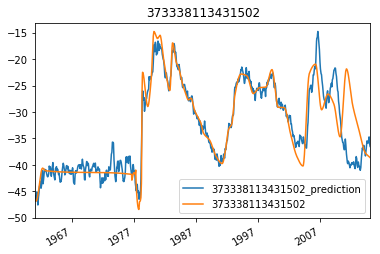

1.1426680088
373419113434201
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


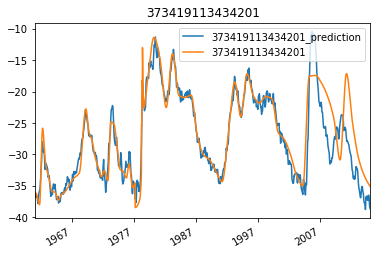

1.16050195694
373527113415101
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


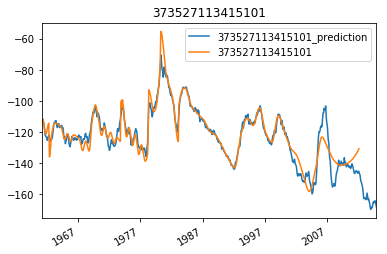

1.78120303154
373644113411501
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


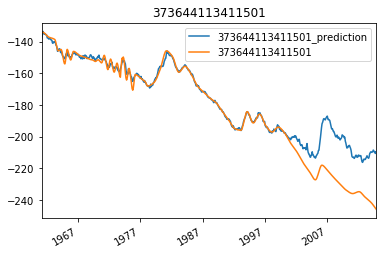

1.67444610596
373735113393801
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


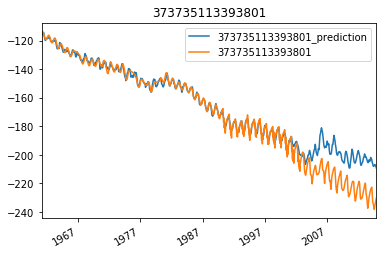

1.2894179821
373854113411501
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


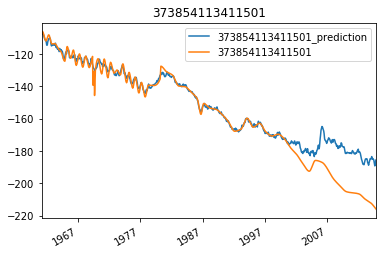

1.10046195984
374020113343101
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


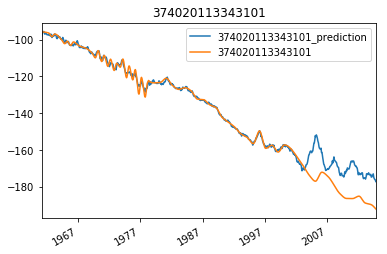

1.10149693489
374041113373501
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


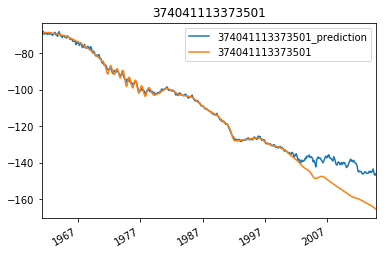

1.25310921669
374053113415101
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


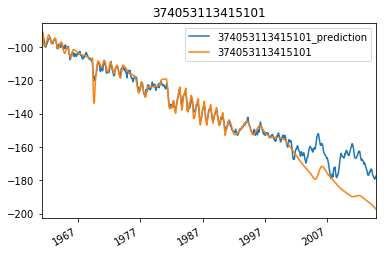

1.00041389465
374228113420101
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


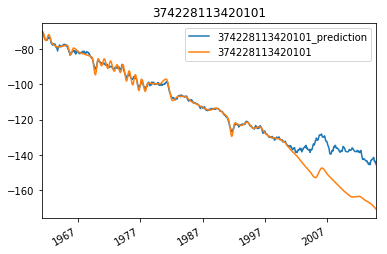

1.24294900894
374252113385801
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


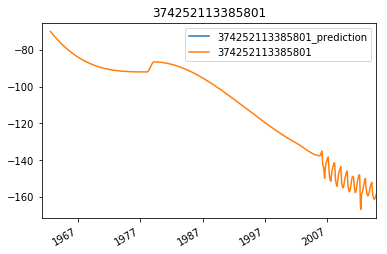

0.885579109192
374319113415201
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


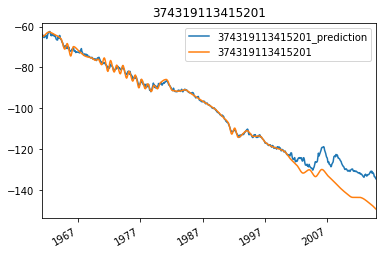

0.951136827469
374344113322403
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


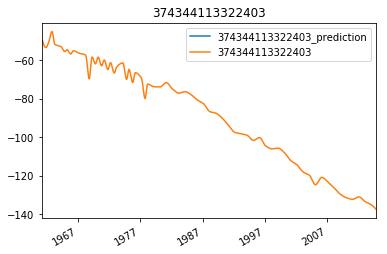

1.26246404648
374411113305101
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


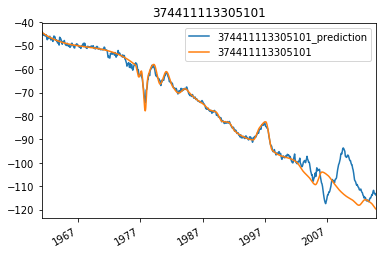

1.81624698639
374445113444501
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


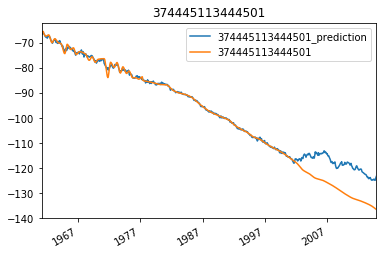

1.33861684799
374503113313701
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


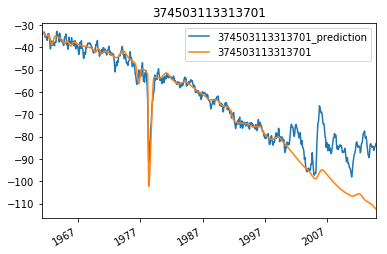

1.22049403191
374505113433701
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


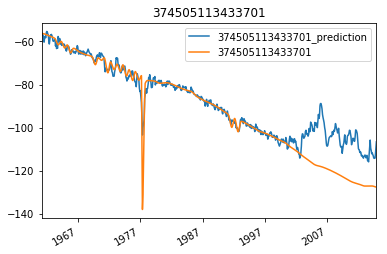

1.24884009361
374649113310201
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


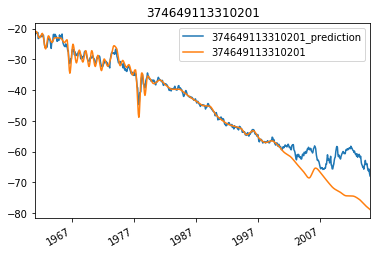

1.22175884247
374649113342501
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


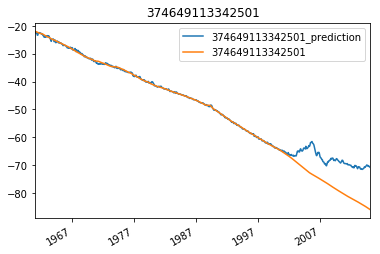

1.18397712708
374649113444801
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


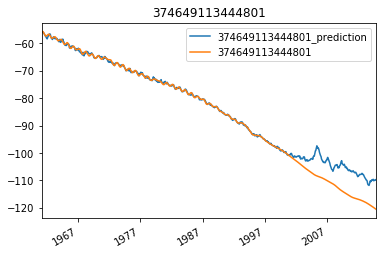

1.21146702766
374808113420301
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


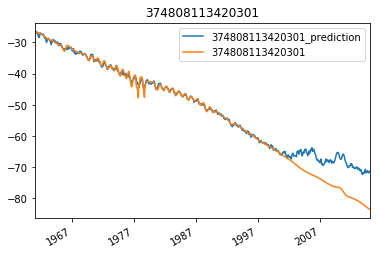

1.07776808739
374833113402401
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


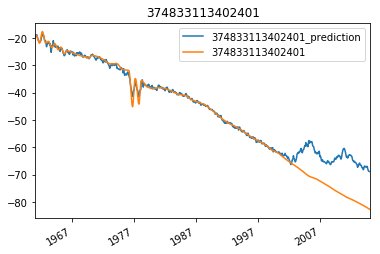

1.01950907707
375324113345301
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


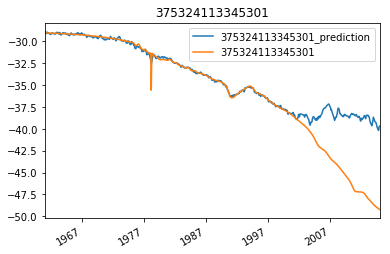

0.984879016876
375429113403901
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


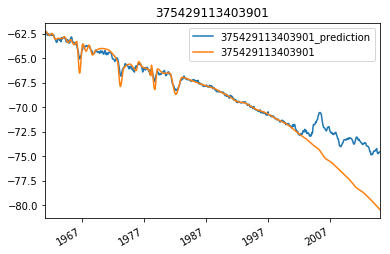

1.00568199158
375531113361901
Input Weight shape: (86, 500)
(1741, 500)
(500,)
Output weights shape: (500,)
(2154, 500)


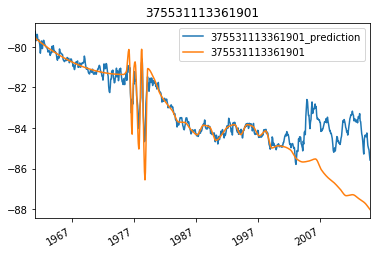

1.03594017029
time elapsed:  30.261909008


In [21]:
pp = PdfPages('multipage.pdf')
st1=t.time()
#for each well in the dataframe, this loop uses the training data from 1958 to 2000 to fit a model for the timeseries
#using the Extreme Learning Machine Method
#After fitting the model, the model is used to predict the groudnwater levels in each well from 2000 to 2014
#The resulting timeseries are shown for each well.
#The actual data is in orange and the predicition is in blue
#All plots are also saved to a pdf called'multipage.pdf' so they can be easily accessed and viewed later

for well in mywells:
    start=t.time()
    thewell=[well]
    print(well)
    #The following lines separate out the training input values (tx) and output values (ty)
    #tx is a matrix of the monthly, yearly, 3-year, 5-year, and 10-year average values of soilw and pdsi
    #ty is a vector of the monthly average depth to water table value for the specified well
    normed_train_labels=normed_train_x[well]
    tx_df=normed_train_x[names]
    allx_df=normed_test_x[names]
#     print(names)
#     tx_df=normed_train_x.drop(thewell,axis=1)
#     allx_df=normed_test_x.drop(thewell,axis=1)
    tx=tx_df.values
    x1=np.column_stack(np.ones(tx.shape[0])).T
    tx=np.hstack((tx,x1))
    ty=normed_train_labels.values
    INPUT_LENGTH=tx.shape[1]
    HIDDEN_UNITS=500
    lamb=100
    Win=np.random.normal(size=[INPUT_LENGTH, HIDDEN_UNITS])
    b=np.random.normal(size=[HIDDEN_UNITS])
    print('Input Weight shape: {shape}'.format(shape=Win.shape))
    def input_to_hidden(x):
        a=np.dot(x,Win)+b
        print(a.shape)
        a=np.maximum(a,0,a)#relu
        return a
    X=input_to_hidden(tx)
    Xt=np.transpose(X)
    I=np.identity(X.shape[1])
    I[X.shape[1]-1,X.shape[1]-1]=0
    I[X.shape[1]-2,X.shape[1]-2]=0
    Wout=np.linalg.lstsq(X.T.dot(X) + lamb * I, X.T.dot(ty))[0]
    print(Wout.shape)
    print('Output weights shape: {shape}'.format(shape=Wout.shape))
    def predict(x):
        x=input_to_hidden(x)
        y=np.dot(x,Wout)
        return y
    allx=allx_df.values
    A1=np.column_stack(np.ones(allx.shape[0])).T
    allx=np.hstack((allx,A1))
    test_predictions=predict(allx)
    
    prediction=str(well)+"_prediction"

    
    combined_df[prediction]=test_predictions
    combined_df[prediction]=combined_df[prediction]*(train_df[well].max()-train_df[well].min())+train_df[well].min()
    combined_df[[prediction,well]].plot()
    plt.title(well)
    plt.legend()
    pp.savefig()
    plt.show()
    plt.close()
    print(t.time()-start)
pp.close()
print("time elapsed: ",t.time()-st1)

1740


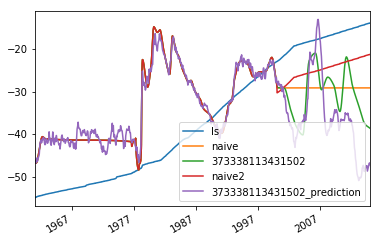

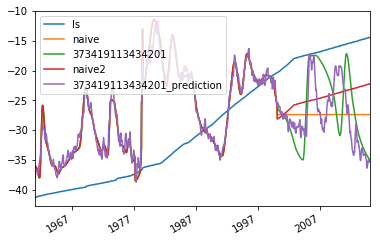

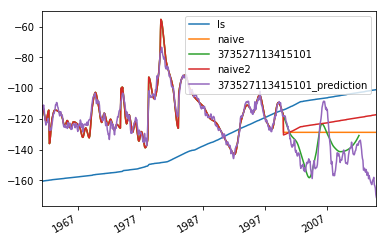

/home/student/tethys/miniconda/envs/tethys/lib/python2.7/site-packages/HydroErr/HydroErr.py:6250: UserWarning: Row(s) [345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362
 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380
 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398
 399 400 401 402 403 404 405 406 407 408 409 410 411 412] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  UserWarning)
/home/student/tethys/miniconda/envs/tethys/lib/python2.7/site-packages/HydroErr/HydroErr.py:6250: UserWarning: Row(s) [345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362
 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380
 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398
 399 400 401 402 403 404 405 406 407 408 409 410 411 412] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  UserWarning)
/home/student/tethys/m

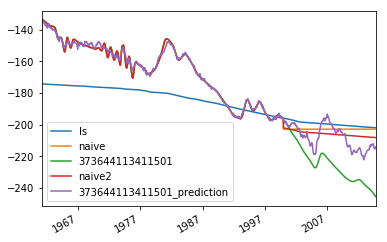

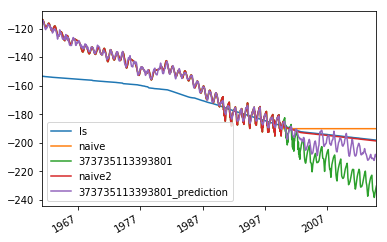

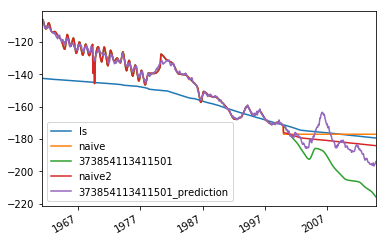

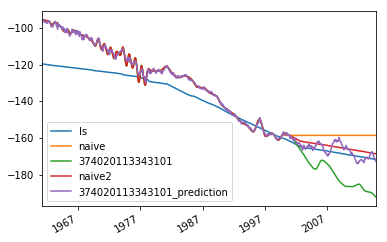

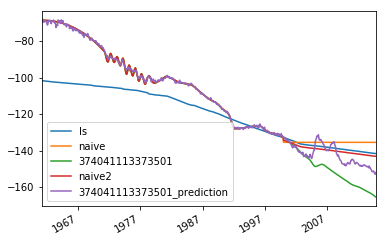

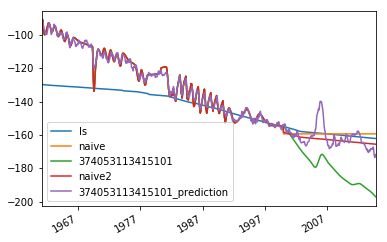

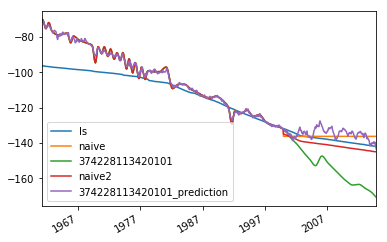

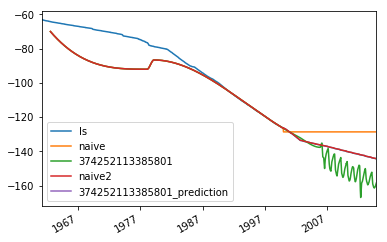

/home/student/tethys/miniconda/envs/tethys/lib/python2.7/site-packages/HydroErr/HydroErr.py:6250: UserWarning: Row(s) [   0    1    2 ... 1738 1739 1740] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  UserWarning)


error


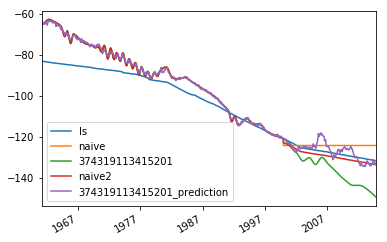

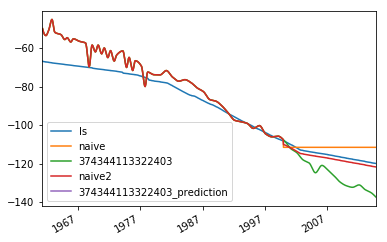

/home/student/tethys/miniconda/envs/tethys/lib/python2.7/site-packages/HydroErr/HydroErr.py:6250: UserWarning: Row(s) [   0    1    2 ... 1738 1739 1740] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  UserWarning)


error


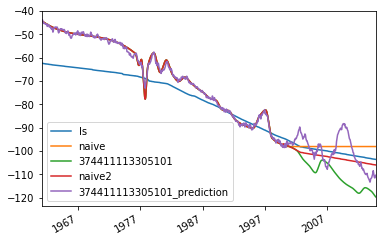

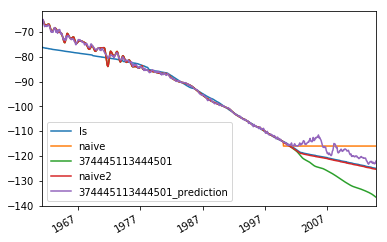

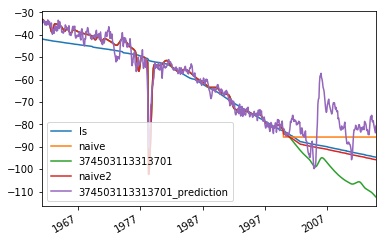

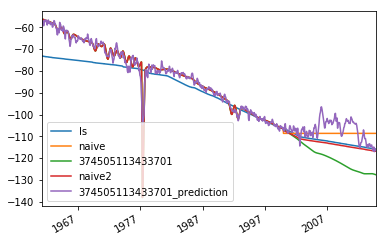

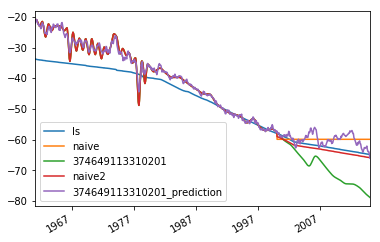

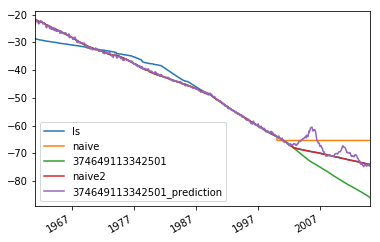

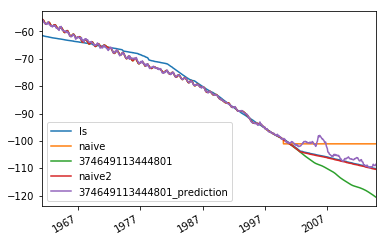

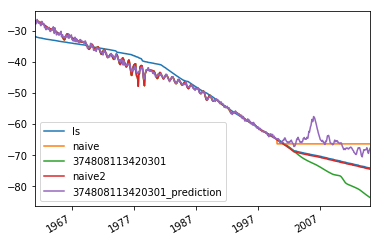

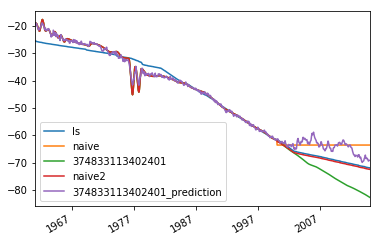

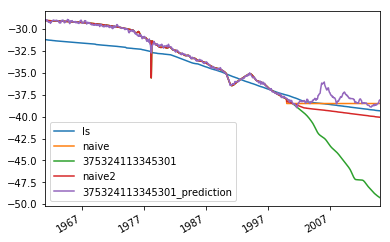

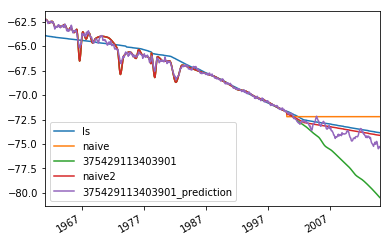

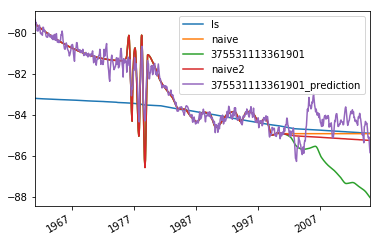

                 training   testing  least squares     naive   lsnaive
373338113431502  0.037157  0.411835       0.752631  0.288241  0.423351
373419113434201  0.036403  0.280722       0.635519  0.313253  0.335044
373527113415101  0.036811  0.219692       0.893571  0.338936  0.464283
373644113411501  0.016735  0.416547       0.598003  0.542332  0.470872
373735113393801  0.016672  0.278401       0.395190  0.479990  0.385352
373854113411501  0.018548  0.370774       0.518987  0.519522  0.415570
374020113343101  0.013500  0.380676       0.338862  0.581650  0.411405
374041113373501  0.009505  0.310607       0.436032  0.541159  0.394850
374053113415101  0.025233  0.495938       0.536792  0.553030  0.458768
374228113420101  0.012596  0.572536       0.472276  0.541948  0.396190
374319113415201  0.010273  0.380067       0.362780  0.510443  0.300638
374411113305101  0.016932  0.503325       0.424032  0.540440  0.335422
374445113444501  0.008133  0.450528       0.301575  0.547080  0.287388
374503

In [18]:
import HydroErr as he
import statsmodels.api as sm
training_set=combined_df.loc[train_df.index]
testing_set=combined_df.drop(train_df.index)
tr_errors=[]
te_errors=[]
tls_errors=[]
naive_errors=[]
combined_errors=[]
date1='2000'
sdate='1990'
naive_date=combined_df.index.get_loc(str(date1)+'-12-31 00:00:00',method='nearest')
print(naive_date)
final_wells=copy.deepcopy(mywells)
for well in mywells:
    prediction=str(well)+"_prediction"
    combined_df['naive']=combined_df[well]
    combined_df['naive'][date1:]=combined_df[well][naive_date]
    model = sm.OLS(combined_df[well][sdate:date1], sm.add_constant(combined_df['linear'][sdate:date1])).fit()
    b,a=model.params
    combined_df['ls']=a*combined_df['linear']+b
    combined_df['naive2']=combined_df[well]
    combined_df['naive2'][date1:]=combined_df['ls'][date1:]-combined_df['ls'][naive_date]+combined_df[well][naive_date]
    combined_df[['ls','naive',well,'naive2',prediction]].plot()
    plt.show()
    try:
        training_set=combined_df.loc[train_df.index]
        testing_set=combined_df.drop(train_df.index)
        d=he.nrmse_range(training_set[prediction],training_set[well])
        tr_errors.append(d)
        d=he.nrmse_range(testing_set[prediction],testing_set[well])
        te_errors.append(d)
        d=he.nrmse_range(testing_set['ls'],testing_set[well])
        tls_errors.append(d)
        d=he.nrmse_range(testing_set['naive'],testing_set[well])
        naive_errors.append(d)
        d=he.nrmse_range(testing_set['naive2'],testing_set[well])
        combined_errors.append(d)
    except:
        final_wells.remove(well)
        print("error")
errors=np.column_stack((tr_errors,te_errors,tls_errors,naive_errors,combined_errors))
error_df=pd.DataFrame(index=final_wells,columns=['training','testing','least squares','naive','lsnaive'],data=errors)
error=error_df['testing'].mean()
print(error_df)
print(str(lamb)," regularization:", error)